
<br>


# <span style="color:#5E6997"> Unleashing the Power of Deep Reinforcement Learning for Trading </span>


<br>
    


## <span style="color:#5E6997"> Data Engineering </span> <a class="anchor" id="data_eng"></a>

In [1]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
pip install 'shimmy>=0.2.1'

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import warnings
warnings.filterwarnings("ignore")

#Portfolio Tracking Initialization
portfolio_values = []  # List to record portfolio value at each time step

In [4]:
df = pd.read_csv('/content/crypto_data.csv')
print(df.columns)
df.head()

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume usdt',
       'tradecount', 'token', 'hour', 'day'],
      dtype='object')


,date,symbol,open,high,low,close,volume usdt,tradecount,token,hour,day
0,2020-12-25 05:00:00,1INCHUSDT,0.2000,3.0885,0.2000,2.5826,35530516,48768,1INCH,5,Friday
1,2020-12-25 06:00:00,1INCHUSDT,2.5824,2.6900,2.2249,2.5059,22440875,31099,1INCH,6,Friday
2,2020-12-25 07:00:00,1INCHUSDT,2.5152,2.8870,2.3609,2.6237,21300426,33001,1INCH,7,Friday
3,2020-12-25 08:00:00,1INCHUSDT,2.6318,2.8247,2.4650,2.6134,17491813,30459,1INCH,8,Friday
4,2020-12-25 09:00:00,1INCHUSDT,2.6104,2.7498,2.5629,2.6365,9919400,21023,1INCH,9,Friday


In [5]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

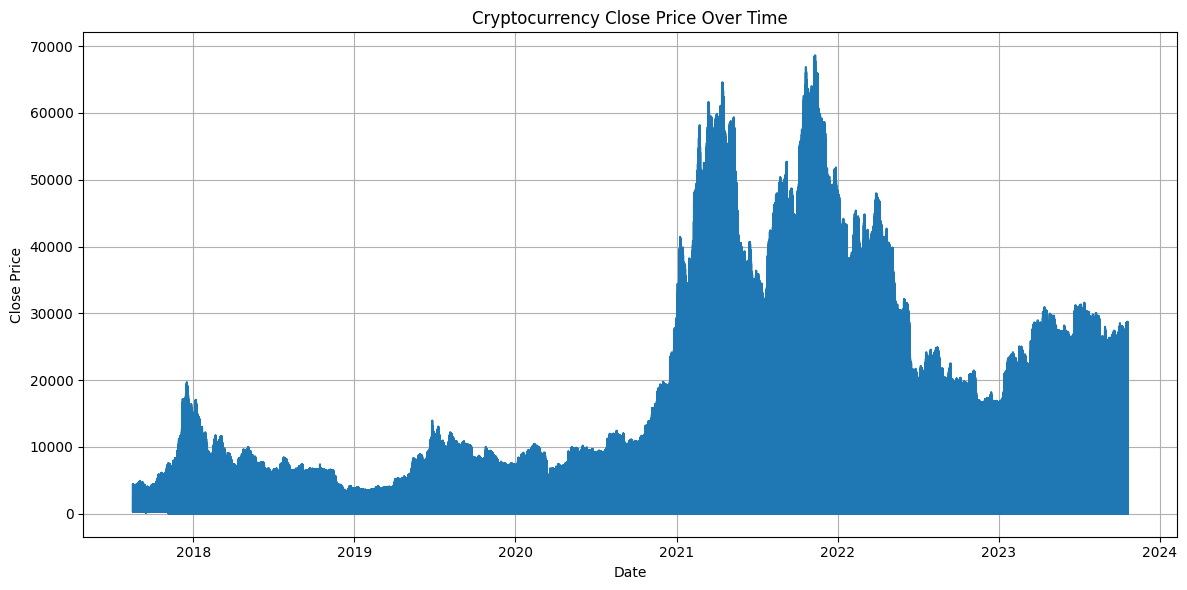

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cryptocurrency Close Price Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
start_date = '2020-08-17 04:00:00'
end_date = '2023-10-19 23:00:00'

In [8]:
data_df = df.copy(deep=True)

In [9]:
data_df = data_df[(data_df['token'] == 'BTC') & (data_df['date'] >= start_date) & (data_df['date'] <= end_date)]

In [10]:
data_df.columns

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume usdt',
       'tradecount', 'token', 'hour', 'day'],
      dtype='object')

### Mapping 'day' days to numerical values

In [11]:
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

data_df['day'] = data_df['day'].apply(lambda x: day_mapping[x])

### Creating new columns EMAs (EMA 13 25 32 100 200)

In [12]:
data_df['ema_13'] = data_df['close'].ewm(span=13).mean()
data_df['ema_25'] = data_df['close'].ewm(span=25).mean()
data_df['ema_32'] = data_df['close'].ewm(span=32).mean()
data_df['ema_100'] = data_df['close'].ewm(span=100).mean()
data_df['ema_200'] = data_df['close'].ewm(span=200).mean()

### Creating Candle Volatility Against Price Close (high - low / close)

In [13]:
data_df['vol_close'] = (data_df['high'] - data_df['low']) / data_df['close']

### Creating EMA for Candle Volatility/Price

In [14]:
# EMA for 2 hours (candles)
data_df['vol_close_ema_3'] = data_df['vol_close'].ewm(span=3, adjust=False).mean()

# EMA for 4 hours (candles)
data_df['vol_close_ema_6'] = data_df['vol_close'].ewm(span=6, adjust=False).mean()

# EMA for 8 hours ((candles)
data_df['vol_close_ema_12'] = data_df['vol_close'].ewm(span=12, adjust=False).mean()

In [15]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27812 entries, 343607 to 371418
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              27812 non-null  datetime64[ns]
 1   symbol            27812 non-null  object        
 2   open              27812 non-null  float64       
 3   high              27812 non-null  float64       
 4   low               27812 non-null  float64       
 5   close             27812 non-null  float64       
 6   volume usdt       27812 non-null  int64         
 7   tradecount        27812 non-null  int64         
 8   token             27812 non-null  object        
 9   hour              27812 non-null  int64         
 10  day               27812 non-null  int64         
 11  ema_13            27812 non-null  float64       
 12  ema_25            27812 non-null  float64       
 13  ema_32            27812 non-null  float64       
 14  ema_100           278

In [16]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [17]:
columns_to_drop = ['symbol', 'token']
data_df = data_df.drop(columns=columns_to_drop)

In [18]:
#data_df = data_df.astype(float)
#data_df.set_index('date', inplace=True)

In [19]:
data_df.to_csv('data_featured.csv', index=False)

In [20]:
train_df = data_df.copy(deep=True)
train_df.reset_index(drop=True, inplace=True)

In [21]:
train_df.head()

,date,open,high,low,close,volume usdt,tradecount,hour,day,ema_13,ema_25,ema_32,ema_100,ema_200,vol_close,vol_close_ema_3,vol_close_ema_6,vol_close_ema_12
0,2020-08-17 04:00:00,11844.72,11858.91,11802.35,11809.38,17196539,28800,4,1,11809.380000,11809.380000,11809.380000,11809.380000,11809.380000,0.004789,0.004789,0.004789,0.004789
1,2020-08-17 05:00:00,11809.39,11836.90,11790.00,11800.01,19958274,28571,5,1,11804.334615,11804.507600,11804.548594,11804.648150,11804.671575,0.003975,0.004382,0.004557,0.004664
2,2020-08-17 06:00:00,11800.00,11846.74,11785.23,11806.37,19327915,29762,6,1,11805.119921,11805.178699,11805.194058,11805.233617,11805.243387,0.005210,0.004796,0.004743,0.004748
3,2020-08-17 07:00:00,11806.37,11843.01,11792.32,11807.21,22698672,33111,7,1,11805.768697,11805.749021,11805.746245,11805.742633,11805.742440,0.004293,0.004545,0.004615,0.004678
4,2020-08-17 08:00:00,11806.94,11885.00,11806.91,11868.77,28031116,37458,8,1,11822.518351,11820.447106,11819.974205,11818.857316,11818.601316,0.006579,0.005562,0.005176,0.004971


In [ ]:
"""df_test = data_df[10000:]
df_test = df_test.reset_index(drop=True)"""

## <span style="color:#5E6997"> DRL Environment Architecture </span> <a class="anchor" id="env"></a>

# DRL Environment v1

In [22]:
class CryptoTradingEnv(gym.Env):
    def __init__(self, data, take_profit_position_range=(0.10, 0.80), stop_loss_position_range=(0.00, 0.15), max_stop_loss_position=0.30):
        super(CryptoTradingEnv, self).__init__()

        self.data = data
        self.n_steps = len(data)
        self.current_step = 0
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.position = 0
        self.position_open = 0 # Price at which the position was opened
        self.num_trades = 0  # Number of trades
        self.profit_loss = 0  # PnL Profit/Loss
        self.max_stop_loss_position = max_stop_loss_position

        self.take_profit_position_range = take_profit_position_range
        self.stop_loss_position_range = stop_loss_position_range

        # 0=Hold, 1=Open Position, 2=Close Position
        self.action_space = gym.spaces.Discrete(3)

        # Observations
        n_features = 15
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(n_features,))

        self.episode_returns = []
        self.cumulative_returns = 0
        self.winning_trades = 0
        self.losing_trades = 0
        self.hourly_returns = []

        self.overall_rewards = 0


    def step(self, action):
        self.current_step += 1
        done = False

        reward = 0
        trade_outcome = 0
        trade_within_range = False

        if action == 1:  # Open Position
            if self.position == 0:  # Only open a position if not already in a trade
                position_size = 0.05 * self.balance

                self.position_open = self.data.loc[self.current_step, 'open']
                self.position = 1
                self.num_trades += 1
                print(f"Opened trade at step {self.current_step} with position size: {position_size:.2f}")
        elif action == 2:  # Close Position
            if self.position == 1:  # Only close a position if currently in a trade
                position_close = self.data.loc[self.current_step, 'open']
                trade_outcome = position_close - self.position_open
                self.profit_loss += trade_outcome
                self.position = 0
                self.position_open = 0
                print(f"Closed trade at step {self.current_step}")
                print(f"------------------------------> Trade outcome: {trade_outcome}")

                self.balance += trade_outcome

                # Check for take profit and stop loss
                if trade_outcome > 0:
                    if trade_outcome >= self.take_profit_position_range[0] * self.position:
                        reward = 1  # Trade reached take profit
                        self.winning_trades += 1  # +1 winning trades count
                        if trade_outcome <= self.take_profit_position_range[1] * self.position and trade_outcome >= self.take_profit_position_range[0] * self.position:
                           # self.trade_within_range = True
                            print("Trade reached take profit")
                elif trade_outcome < 0:
                    if abs(trade_outcome) >= self.max_stop_loss_position * self.position:
                        reward = -1.7  # Trade reached the maximum stop loss
                        self.losing_trades += 1  # +1 losing trades count
                        print("Trade reached the maximum stop loss")
                    elif abs(trade_outcome) >= self.stop_loss_position_range[0] * self.position:
                        reward = -1  # Trade reached the stop loss
                        self.losing_trades += 1  # +1 losing trades count
                        print("Trade reached stop loss")
                    else:
                        # No reward (positive and negative) if the trade closed with no loss
                        reward = 0
                        print("Trade closed with no loss")

#                if trade_within_range:
#                    self.winning_trade_within_range += 1

    # reward based on profit/loss of the last trade
#        reward += trade_outcome
        if trade_outcome > 0:
            reward += 0.5
        print(f"Reward: {reward}")

        # reward for this episode
        self.episode_returns.append(reward)

        # cumulative returns
        self.cumulative_returns += reward

        # hourly returns for daily return calculation
#        self.hourly_returns.append(reward)

        self.overall_rewards += reward

        if self.current_step >= self.n_steps:
            done = True

        next_state = self.get_observation()
        return next_state, reward, done, {}


    def reset(self):
        self.current_step = 0
        self.position = 0
        self.position_open = 0
        episode_return = np.sum(self.episode_returns)
        self.episode_returns = []
        self.cumulative_returns += episode_return
        self.current_week_start = 0
        return self.get_observation()

    def render(self, mode='human'):
        if mode == 'human':
            print(f"Step: {self.current_step}")
            print(f"Open Position: {self.position}")
            print(f"Trades: {self.num_trades} | Profit/Loss: {self.profit_loss:.2f}")
            print(f"Balance: {self.balance:.2f}")
            print(f"Winning Trades: {self.winning_trades} | Losing Trades: {self.losing_trades}")
            print(f"Overall Rewards: {self.overall_rewards:.2f}")
            print(self.data.loc[self.current_step])

    def close(self):
        pass

    def get_observation(self):
        obs = self.data.loc[self.current_step, [
            'open', 'high', 'low', 'close', 'volume usdt', 'hour', 'day',
            'ema_13', 'ema_25', 'ema_32', 'ema_100', 'ema_200', 'vol_close_ema_3', 'vol_close_ema_6', 'vol_close_ema_12'
        ]].values.astype(np.float32)
        return obs / obs.max()


In [23]:
env = CryptoTradingEnv(df)
print(env.observation_space, env.action_space)
"""You’ve created a trading environment (env) based on your price DataFrame, and then you ask it to tell you two things about how it sees the world and what actions you can take. The output

scss
Copy
Edit
Box(0.0, 1.0, (15,), float32) Discrete(3)
is simply the environment’s way of describing:

Observation Space
Box(0.0, 1.0, (15,), float32) means the agent observes a 15-element array (think of 15 numbers in a row) where each number is a continuous (decimal) value ranging from 0.0 to 1.0 and stored as a 32-bit float
Gym Library
.

In everyday terms, imagine you have 15 sliders, each one can slide anywhere between 0 and 1, and together they form the full “state” the agent sees at each step
DigitalOcean
.

Action Space
Discrete(3) means there are exactly three possible actions the agent can choose from, labeled 0, 1, or 2
Stack Overflow
.

Think of it like a multiple-choice question with three options—each action is one of those options, and you can’t pick anything else.

So in simple words:

Observation space: What you’ll feed into your model—15 numbers between 0 and 1.

Action space: What your model can output—exactly one of three choices.


"""

Box(0.0, 1.0, (15,), float32) Discrete(3)


'You’ve created a trading environment (env) based on your price DataFrame, and then you ask it to tell you two things about how it sees the world and what actions you can take. The output\n\nscss\nCopy\nEdit\nBox(0.0, 1.0, (15,), float32) Discrete(3)\nis simply the environment’s way of describing:\n\nObservation Space\nBox(0.0, 1.0, (15,), float32) means the agent observes a 15-element array (think of 15 numbers in a row) where each number is a continuous (decimal) value ranging from 0.0 to 1.0 and stored as a 32-bit float\nGym Library\n.\n\nIn everyday terms, imagine you have 15 sliders, each one can slide anywhere between 0 and 1, and together they form the full “state” the agent sees at each step\nDigitalOcean\n.\n\nAction Space\nDiscrete(3) means there are exactly three possible actions the agent can choose from, labeled 0, 1, or 2\nStack Overflow\n.\n\nThink of it like a multiple-choice question with three options—each action is one of those options, and you can’t pick anything el

## <span style="color:#5E6997"> DRL Agent Architecture </span> <a class="anchor" id="agent"></a>

# DRL Agent v1

In [24]:
num_episodes = 5000
print_interval = 100

env = CryptoTradingEnv(train_df)
obs = env.reset()
agent = PPO("MlpPolicy", DummyVecEnv([lambda: env]), verbose=1, tensorboard_log="./ppo_logs/")
max_steps = 50000

# ── Reward & Portfolio logging ──
episode_rewards = []
portfolio_values = []  # make sure you initialized this earlier

for episode in range(num_episodes):
    obs = np.array(obs, dtype=np.float32)
    action, _ = agent.predict(obs, deterministic=False)

    remaining_steps = min(max_steps - env.current_step, env.n_steps)

    if remaining_steps > 0:
        obs, reward, done, _ = env.step(action)
        env.render()

        # Record Portfolio Value
        portfolio_values.append(env.balance)  # or env.net_worth if you prefer

        # record this episode’s final (cumulative) return
        episode_rewards.append(env.cumulative_returns)

    # <-- this if lines up with the for, not deeper or shallower
    if (episode + 1) % print_interval == 0:
        print(f"Episode {episode + 1}: Final Rewards: {env.cumulative_returns:.2f} | Total Trades: {env.num_trades}")


Streaming output truncated to the last 5000 lines.
date                2021-03-05 17:00:00
open                           47656.65
high                           48237.42
low                             47320.0
close                          48096.01
volume usdt                   169030692
tradecount                        73267
hour                                 17
day                                   5
ema_13                     47699.442281
ema_25                     47882.183425
ema_32                     48037.703504
ema_100                    48465.935853
ema_200                    48630.175604
vol_close                      0.019075
vol_close_ema_3                0.019064
vol_close_ema_6                0.018156
vol_close_ema_12               0.017186
Name: 4813, dtype: object
Reward: 0
Step: 4814
Open Position: 1
Trades: 759 | Profit/Loss: 12744.67
Balance: 22744.67
Winning Trades: 403 | Losing Trades: 355
Overall Rewards: 1.00
date                2021-03-05 18:00:00
open    

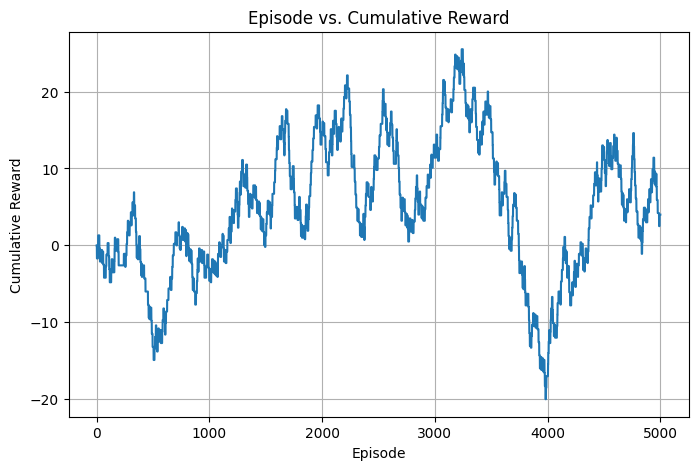

'A reward curve plots, for each training episode, the total reward (also called the return) that your agent has collected.\nBy looking at how this curve moves over time, you can see how well and how quickly your agent is learning to achieve its goals.'

In [26]:
# ── Reward Curve: Episode vs. Cumulative Reward ──
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_episodes + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Episode vs. Cumulative Reward")
plt.grid(True)
plt.show()

"""A reward curve plots, for each training episode, the total reward (also called the return) that your agent has collected.
By looking at how this curve moves over time, you can see how well and how quickly your agent is learning to achieve its goals."""


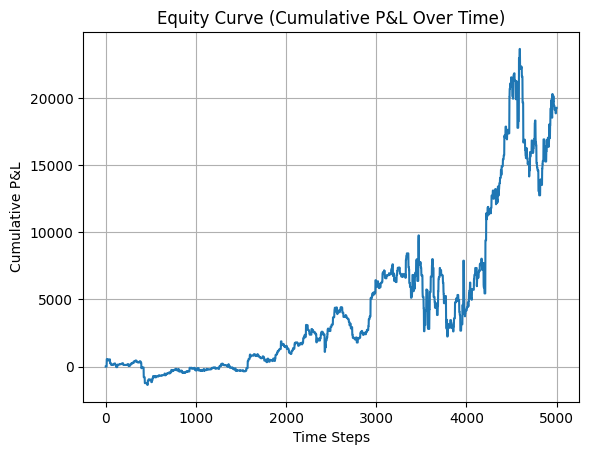

In [27]:
# === Equity Curve (Cumulative P&L Over Time) ===
# Ensure `portfolio_values` is defined: a list of floats
try:
    portfolio_values
except NameError:
    raise NameError("'portfolio_values' is not defined. Please define portfolio_values = <your list of values> before this cell.")

# Compute equity curve as P&L relative to initial value
initial_val = portfolio_values[0]
equity_curve = [pv - initial_val for pv in portfolio_values]

# Plotting
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(equity_curve)), equity_curve)
plt.title('Equity Curve (Cumulative P&L Over Time)')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative P&L')
plt.grid(True)
plt.show()

In [28]:
# === Maximum Drawdown Calculation ===
# Make sure portfolio_values is your history of NAVs/prices
try:
    portfolio_values
except NameError:
    raise NameError("'portfolio_values' is not defined. Define it before this cell.")

import numpy as np
pv = np.array(portfolio_values)

# 1. Running peak
running_max = np.maximum.accumulate(pv)
# 2. Drawdowns from peaks
drawdowns = (pv - running_max) / running_max
# 3. Worst peak-to-trough
max_dd = drawdowns.min()

print(f"Maximum Drawdown: {max_dd * 100:.2f}%")


Maximum Drawdown: -38.07%


In [29]:
# --- Compute Period Returns ---
pv = np.array(portfolio_values)
returns = (pv[1:] / pv[:-1] - 1).tolist()
print(f"Computed {len(returns)} returns. Sample: {returns[:5]}")


Computed 4999 returns. Sample: [0.0, -0.00030199999999991345, 0.0, 0.0, 0.0]


In [30]:
# === Sharpe Ratio Calculation ===
# Make sure you’ve already created a `returns` list (see step 2)

try:
    returns
except NameError:
    raise NameError("'returns' is not defined. Run the returns computation cell first, dammit!")

import numpy as np

# Annualization factor: 252 for trading days (adjust if you’re using a different frequency)
ann_factor = 252

mean_ret = np.mean(returns)
std_ret  = np.std(returns)

sharpe_ratio = (mean_ret / std_ret) * np.sqrt(ann_factor)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: 0.37


### Save configuration

In [31]:
agent.save('v1_ppodrl')

# Test Validation Phase

### Import / load validation data

In [32]:
val_data = train_df

In [33]:
# initialize lists to collect rewards
train_rewards = []
val_rewards = []

# make a separate VecEnv for validation
from stable_baselines3.common.vec_env import DummyVecEnv
eval_env = DummyVecEnv([lambda: CryptoTradingEnv(val_data)])


In [34]:
val_data = val_data.reset_index(drop=True)

In [35]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27812 entries, 0 to 27811
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              27812 non-null  datetime64[ns]
 1   open              27812 non-null  float64       
 2   high              27812 non-null  float64       
 3   low               27812 non-null  float64       
 4   close             27812 non-null  float64       
 5   volume usdt       27812 non-null  int64         
 6   tradecount        27812 non-null  int64         
 7   hour              27812 non-null  int64         
 8   day               27812 non-null  int64         
 9   ema_13            27812 non-null  float64       
 10  ema_25            27812 non-null  float64       
 11  ema_32            27812 non-null  float64       
 12  ema_100           27812 non-null  float64       
 13  ema_200           27812 non-null  float64       
 14  vol_close         2781

In [36]:
val_data.head()

,date,open,high,low,close,volume usdt,tradecount,hour,day,ema_13,ema_25,ema_32,ema_100,ema_200,vol_close,vol_close_ema_3,vol_close_ema_6,vol_close_ema_12
0,2020-08-17 04:00:00,11844.72,11858.91,11802.35,11809.38,17196539,28800,4,1,11809.380000,11809.380000,11809.380000,11809.380000,11809.380000,0.004789,0.004789,0.004789,0.004789
1,2020-08-17 05:00:00,11809.39,11836.90,11790.00,11800.01,19958274,28571,5,1,11804.334615,11804.507600,11804.548594,11804.648150,11804.671575,0.003975,0.004382,0.004557,0.004664
2,2020-08-17 06:00:00,11800.00,11846.74,11785.23,11806.37,19327915,29762,6,1,11805.119921,11805.178699,11805.194058,11805.233617,11805.243387,0.005210,0.004796,0.004743,0.004748
3,2020-08-17 07:00:00,11806.37,11843.01,11792.32,11807.21,22698672,33111,7,1,11805.768697,11805.749021,11805.746245,11805.742633,11805.742440,0.004293,0.004545,0.004615,0.004678
4,2020-08-17 08:00:00,11806.94,11885.00,11806.91,11868.77,28031116,37458,8,1,11822.518351,11820.447106,11819.974205,11818.857316,11818.601316,0.006579,0.005562,0.005176,0.004971


In [37]:
pre_trained_agent = PPO.load('v1_ppodrl')

In [38]:
env_test = CryptoTradingEnv(val_data)
obs = env_test.reset()

num_episodes = 1000

for episode in range(num_episodes):
     obs = np.array(obs, dtype=np.float32)
     action, _ = agent.predict(obs, deterministic=True)

     remaining_steps = min(max_steps - env_test.current_step, env_test.n_steps)

     if remaining_steps > 0:
         obs, reward, done, _ = env_test.step(action)
         env_test.render()

     if (episode + 1) % print_interval == 0:
         print(f"Episode {episode + 1}: Final Rewards: {env_test.cumulative_returns:.2f} | Total Trades: {env_test.num_trades}")

Streaming output truncated to the last 5000 lines.
ema_200                    10770.675847
vol_close                      0.004049
vol_close_ema_3                0.004235
vol_close_ema_6                0.004717
vol_close_ema_12                0.00516
Name: 808, dtype: object
Reward: 0
Step: 809
Open Position: 0
Trades: 0 | Profit/Loss: 0.00
Balance: 10000.00
Winning Trades: 0 | Losing Trades: 0
Overall Rewards: 0.00
date                2020-09-19 21:00:00
open                           11087.31
high                           11087.35
low                             11026.5
close                          11052.18
volume usdt                    12146190
tradecount                        25969
hour                                 21
day                                   6
ema_13                     11048.123356
ema_25                     11017.480572
ema_32                     11003.706262
ema_100                    10895.977357
ema_200                    10773.477734
vol_close           

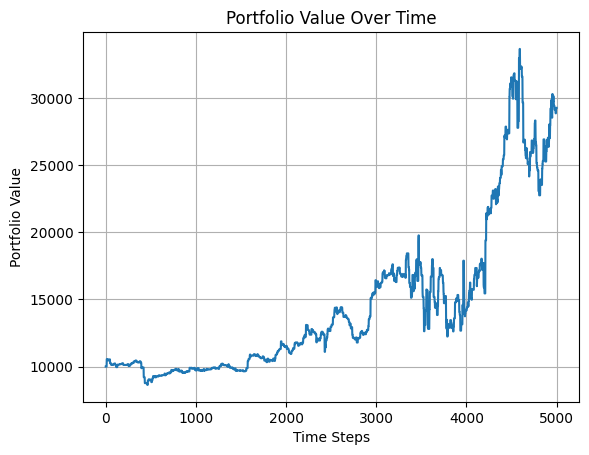

'Portfolio Value Over Time" refers to the tracking and visualization of how the total value of an investment portfolio changes over a specific period.\nIt essentially shows the performance of your investments, including gains and losses, and the overall growth or decline of your portfolio. '

In [39]:
#  Plot Portfolio Value Over Time ====
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(portfolio_values)), portfolio_values)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

"""Portfolio Value Over Time" refers to the tracking and visualization of how the total value of an investment portfolio changes over a specific period.
It essentially shows the performance of your investments, including gains and losses, and the overall growth or decline of your portfolio. """

In [40]:
# === Total Return Calculation ===
# Assumes `portfolio_values` is a list of portfolio values over time
initial_value = portfolio_values[0]
final_value   = portfolio_values[-1]
total_return  = (final_value / initial_value - 1) * 100
print(f"Total Return: {total_return:.2f}%")

Total Return: 192.55%
